In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib as mpl
import plot_utils

In [2]:
methods = {
    # 'n_3r1i': '3 dims\n1 answer',
    # 'n_1r1i': '1 dim\n1 answer',
    'n_1r10i': '1 dim\n10 answers',
    'n_1r20i': '1 dim\n20 answers',
    'n_1r50i': '1 dim\n50 answers',
    's_1r20i': '1 dim\n20 answers\n10 samples',
    'n_1r20i_numeric': '1 dim\n20 answers\nrating-only',
    's_1r20i_numeric': '1 dim\n20 answers\nrating-only\n10 samples',
}

In [3]:
measures = ('novelty', 'feasibility', 'value')

In [4]:
pearson = pd.DataFrame(columns=measures, dtype=float)
spearman = pd.DataFrame(columns=measures, dtype=float)

In [5]:
squid = []
rmsd = []
for method, name in methods.items():
    data = pd.read_excel(f'gpt-ratings/{method}-omni.xlsx')
    for key in measures:
        if key == 'value':
            mask = (data[key]>0) & (data[key]<100_000)
        else:
            mask = data.index>=0
        spearman.loc[name, key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic
        pearson.loc[name, key] = stats.pearsonr(data[mask][key.capitalize()], data[mask][key]).statistic

    for qid in data['Question id'].unique():
        qmask = data['Question id'] == qid
        entry = {'method': name}
        rmsd_entry = {'method': name}
        for key in measures:
            mask = qmask
            if key == 'value':
                mask &= (data[key]>0) & (data[key]<100_000)

            entry[key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic

            x = data[mask][key.capitalize()]
            x_rank = np.empty(x.shape, int)
            x_rank[np.argsort(x)] = np.arange(len(x))

            y = data[mask][key]
            y_rank = np.empty(y.shape, int)
            y_rank[np.argsort(y)] = np.arange(len(y))

            rmsd_entry[key] = np.sqrt(np.mean(np.square(y_rank - x_rank)))

        squid.append(entry)
        rmsd.append(rmsd_entry)
spearman_qid = pd.DataFrame(squid)
rmsd = pd.DataFrame(rmsd)

Text(0, 0.5, '')

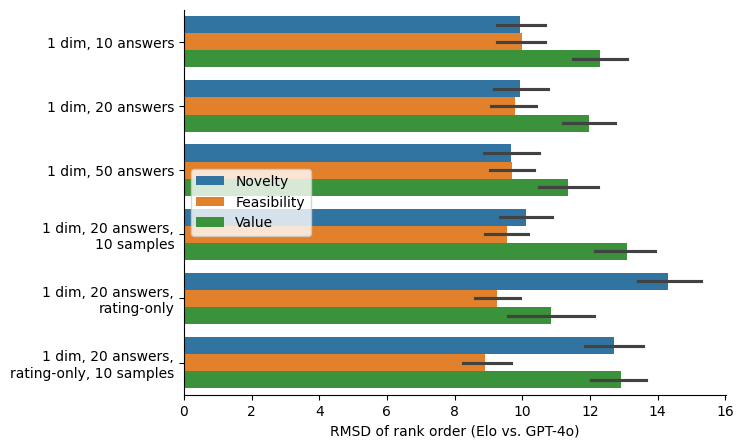

In [12]:
plt.figure(figsize=(7,5))
long = rmsd.set_index('method').melt(value_name='RMSD of rank order (Elo vs. GPT-4o)', var_name='measure', ignore_index=False)
long.index = [s.replace('\n',', ').replace('answers, ','answers,\n') for s in long.index]
ax = sns.barplot(long, y=long.index, x='RMSD of rank order (Elo vs. GPT-4o)', hue='measure')
plt.legend(ax.containers, [m.capitalize() for m in measures], loc='center left')
sns.despine()
plt.ylabel('')

In [13]:
pearson

,novelty,feasibility,value
1 dim\n10 answers,0.621291,0.575914,0.248875
1 dim\n20 answers,0.617105,0.614439,0.264124
1 dim\n50 answers,0.640019,0.625135,0.283532
1 dim\n20 answers\n10 samples,0.609525,0.624505,0.244530
1 dim\n20 answers\nrating-only,0.238059,0.666812,0.179494
1 dim\n20 answers\nrating-only\n10 samples,0.332221,0.698945,0.390073


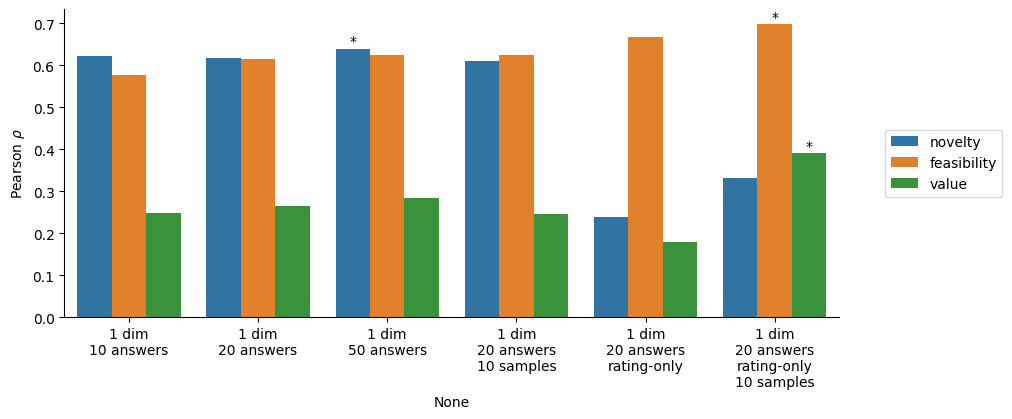

In [14]:
fig, ax = plt.subplots(figsize=(10,4))

long = pearson.melt(value_name='correlation', var_name='measure', ignore_index=False)

imax = [i*len(pearson) + pearson[col].astype('float').argmax() for i, col in enumerate(pearson.columns)]
labels = ['*' if i in imax else '' for i in range(len(long))]

sns.barplot(long, x=long.index, y='correlation', hue='measure', ax=ax)
for i, col in enumerate(pearson.columns):
    jmax = pearson[col].astype('float').argmax()
    labels = ['*' if j == jmax else '' for j in range(len(pearson))]
    ax.bar_label(ax.containers[i], labels)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
ax.set_ylabel('Pearson $\\rho$')
sns.despine(ax=ax)


In [15]:
spearman

,novelty,feasibility,value
1 dim\n10 answers,0.632830,0.613042,0.325938
1 dim\n20 answers,0.626438,0.643059,0.321542
1 dim\n50 answers,0.640827,0.649574,0.381393
1 dim\n20 answers\n10 samples,0.615807,0.648938,0.187173
1 dim\n20 answers\nrating-only,0.231072,0.680069,0.164498
1 dim\n20 answers\nrating-only\n10 samples,0.380814,0.704048,0.373699


In [16]:
mean = spearman_qid.groupby('method').mean()

In [17]:
std = spearman_qid.groupby('method').std()

In [18]:
print('\t'.join(['Method'] + [m.capitalize() for m in measures]))
for method in methods.values():
    m = method.replace('\n', ', ')
    print(m, end='')
    for measure in measures:
        mean_, sd_ = mean.loc[method, measure], std.loc[method, measure]
        print(f'\t{mean_:.2f}\t{sd_:.2f}\t{mean_/sd_:.2f}', end='')
    print()

Method	Novelty	Feasibility	Value
1 dim, 10 answers	0.64	0.10	6.24	0.63	0.12	5.12	0.37	0.16	2.30
1 dim, 20 answers	0.64	0.12	5.24	0.66	0.10	6.28	0.38	0.17	2.21
1 dim, 50 answers	0.66	0.12	5.48	0.67	0.10	7.05	0.47	0.18	2.54
1 dim, 20 answers, 10 samples	0.63	0.12	5.32	0.67	0.10	6.62	0.33	0.19	1.71
1 dim, 20 answers, rating-only	0.24	0.23	1.04	0.69	0.11	6.38	0.25	0.21	1.19
1 dim, 20 answers, rating-only, 10 samples	0.40	0.22	1.85	0.71	0.13	5.51	0.39	0.17	2.37
